In [3]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("working on gpu")
else:
    device = torch.device("cpu")
    print("working on cpu")

working on gpu


In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.drop(self.fc1(out))
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out
    
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight) 

    
model = Classifier()
model.apply(weights_init)
model.to(device)

Classifier(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [5]:
torch.save(model, './model_file/server-global-model_1.pth')

### 서버에서 먼저 global model을 클라이언트에게 전송

In [96]:
#클라이언트와의 접속 확인 
# 클라이언트로 부터 모델 파일 명 recv 
# 클라이언트로부터 모델 파일 recv

#filename = 'server-global-eff-model.pth'

from socket import *
from os.path import exists
import sys
import os 

c = 0 

while c < 2:

    serverSock = socket(AF_INET, SOCK_STREAM)
    serverSock.bind(('',2266))

    serverSock.listen(2)

    con_sock, addr = serverSock.accept()

    print(str(addr),'에서 접속 확인 ! ')


    filename = con_sock.recv(1024)
    print('클라이언트가 요청한 파일 : ', filename.decode())
    data_transferred = 0

    if not exists('./model_file/'+filename.decode()):
        print('파일이 없습니다.')
        sys.exit()

    print("파일 %s 전송 시작" %filename)

    now_dir = os.path.join('./model_file/', filename.decode())

    with open(now_dir, 'rb') as f:
        try :
            data = f.read(4096)
            while data:
                data_transferred += con_sock.send(data)

                data = f.read(4096)

        except Exception as ex:
            print(ex)
        print("전송 완료 %s 전송량 %d" %(filename, data_transferred))
        con_sock.close()
        c += 1

('127.0.0.1', 55399) 에서 접속 확인 ! 
클라이언트가 요청한 파일 :  global-update-2-mnist.pt
파일 b'global-update-2-mnist.pt' 전송 시작
전송 완료 b'global-update-2-mnist.pt' 전송량 5912669
('127.0.0.1', 55400) 에서 접속 확인 ! 
클라이언트가 요청한 파일 :  global-update-2-mnist.pt
파일 b'global-update-2-mnist.pt' 전송 시작
전송 완료 b'global-update-2-mnist.pt' 전송량 5912669


In [ ]:

    
    serverSock = socket(AF_INET, SOCK_STREAM)
    serverSock.bind(('',2267))

    serverSock.listen(1)

    con_sock, addr = serverSock.accept()

    print(str(addr),'에서 접속 확인 ! ')

    filename = con_sock.recv(1024) # 파일 이름 전송받기
    print('받은 파일 이름 : ', filename.decode('utf-8'))

    data = con_sock.recv(2048) 

    data_transferred = 0

    save_dir = './model_file/'

    with open(save_dir+"/"+(filename.decode('utf-8')), 'wb') as f:
        try :
            while data:
                f.write(data)
                data_transferred += len(data)
                data = con_sock.recv(2048) # 파일 내용 전송받기

        except Exception as ex:
            print(ex)
    print('파일 %s 받기 완료. 전송량 %d ' %(filename, data_transferred))
    con_sock.close()

In [1]:
pwd

'D:\\asy10\\FL_project\\mnist\\Server'

### 클라이언트에서 학습 후 파라미터 파일 전송

In [98]:
# 클라이언트와의 접속 확인 
# 클라이언트로 부터 모델 파일 명 recv 
# 클라이언트로부터 모델 파일 recv

from socket import *
from os.path import exists
import sys

serverSock = socket(AF_INET, SOCK_STREAM)
serverSock.bind(('',2266))

serverSock.listen(2)

con_sock, addr = serverSock.accept()

print(str(addr),'에서 접속 확인 ! ')

filename = con_sock.recv(1024) # 파일 이름 전송받기
print('받은 파일 이름 : ', filename.decode('utf-8'))

data = con_sock.recv(2048) 

data_transferred = 0

save_dir = './model_file/'

with open(save_dir+"/"+(filename.decode('utf-8')), 'wb') as f:
    try :
        while data:
            f.write(data)
            data_transferred += len(data)
            data = con_sock.recv(2048) # 파일 내용 전송받기
            
    except Exception as ex:
        print(ex)
print('파일 %s 받기 완료. 전송량 %d ' %(filename, data_transferred))
con_sock.close()

('127.0.0.1', 55475) 에서 접속 확인 ! 
받은 파일 이름 :  mnist-model_2-update-3.pt
파일 b'mnist-model_2-update-3.pt' 받기 완료. 전송량 5908787 


In [99]:
statd_dict_1 = torch.load('./model_file/mnist-model-update-3.pt')
statd_dict_2 = torch.load('./model_file/mnist-model_2-update-3.pt')

In [100]:
statd_dict_1['fc1.weight']

tensor([[-2.9799e-05,  6.0613e-05,  1.0698e-04,  ..., -1.1784e-06,
         -2.2262e-05, -4.2362e-06],
        [ 2.9278e-05, -1.5723e-04,  5.5906e-05,  ..., -1.0382e-05,
          5.6080e-05,  2.1927e-06],
        [-4.2487e-04, -1.2251e-03, -4.5489e-04,  ..., -1.0200e-03,
          1.5172e-04, -5.2835e-05],
        ...,
        [ 7.2093e-03,  1.5104e-02, -3.5292e-03,  ..., -1.6618e-03,
          4.2365e-05,  2.0793e-03],
        [-4.5999e-04, -1.0210e-03,  6.1634e-05,  ..., -5.0425e-05,
         -5.6671e-04, -1.1023e-05],
        [ 5.9236e-05,  9.9567e-05, -1.3406e-04,  ..., -6.4842e-05,
         -8.5240e-06, -1.4281e-06]], device='cuda:0')

In [101]:
statd_dict_1['fc1.bias']

tensor([-2.6253e-05, -1.2397e-05,  1.6772e-03,  2.3051e-02,  4.2092e-04,
        -4.7281e-05, -3.5723e-04,  8.6624e-05, -4.6532e-05, -3.7846e-05,
        -1.2909e-04,  2.6689e-04, -6.0584e-05,  8.0517e-03, -1.3145e-02,
         2.8521e-04,  4.3587e-05, -6.0843e-04,  2.6080e-04, -1.3783e-04,
        -7.8899e-05,  1.8840e-04,  4.3504e-03, -3.2628e-04,  2.1311e-04,
        -1.6742e-03, -2.4840e-03,  5.3718e-04, -5.2079e-04,  1.7721e-03,
        -2.2290e-05,  3.4190e-04,  3.6143e-04, -4.9101e-03, -1.2603e-02,
         9.5224e-03,  9.4484e-03, -1.4175e-05, -3.8204e-04,  1.8189e-04,
         1.4144e-05, -7.7795e-05,  2.6827e-04, -9.4684e-05, -7.6651e-03,
         3.8775e-04,  1.6674e-04, -2.1022e-04, -7.3460e-03,  1.5026e-02,
        -1.1366e-02, -2.7405e-02,  4.0031e-03,  9.3769e-05, -2.1918e-05,
        -4.4814e-05, -1.7738e-04,  5.2313e-05, -2.5919e-05, -6.9121e-03,
         1.1438e-04,  7.7223e-03, -3.5120e-03, -6.4585e-03, -4.6247e-04,
        -5.0225e-04,  4.3918e-04, -2.7455e-03,  7.4

In [102]:
statd_dict_2['fc1.weight']

tensor([[-3.0133e-05,  5.8464e-05,  1.0467e-04,  ..., -3.6051e-07,
         -2.2546e-05, -4.5069e-06],
        [ 2.7994e-05, -1.6041e-04,  5.5366e-05,  ..., -1.1637e-05,
          5.5349e-05,  2.3733e-06],
        [-4.2684e-04, -1.2326e-03, -4.2191e-04,  ..., -1.0144e-03,
          1.4134e-04, -5.4005e-05],
        ...,
        [ 7.2014e-03,  1.4843e-02, -3.4852e-03,  ..., -1.6995e-03,
          3.0416e-05,  2.0667e-03],
        [-4.5257e-04, -1.0161e-03,  6.7086e-05,  ..., -4.6336e-05,
         -5.6426e-04, -1.2357e-05],
        [ 5.9423e-05,  9.9436e-05, -1.3228e-04,  ..., -6.4071e-05,
         -8.7837e-06, -1.3908e-06]], device='cuda:0')

In [ ]:
statd_dict_2['fc.bias']

### fc_weight -> 2차원 텐서, _fc.bias -> 1차원 텐서
- 두 개의 클라이언트 모델에서 학습한 weight 파라미터를 평균 내서 global 모델에 넣어준다

In [104]:
global_fc1_weight = (statd_dict_1['fc1.weight'] + statd_dict_2['fc1.weight'])/2
global_fc2_weight = (statd_dict_1['fc2.weight'] + statd_dict_2['fc2.weight'])/2
global_fc3_weight = (statd_dict_1['fc3.weight'] + statd_dict_2['fc3.weight'])/2

In [105]:
global_fc3_weight 

tensor([[ 0.0332, -0.0032, -0.0156,  ...,  0.0166, -0.0063, -0.0797],
        [ 0.0046, -0.0077,  0.0052,  ..., -0.0024, -0.0133,  0.1216],
        [-0.0094,  0.0100,  0.0009,  ..., -0.0061,  0.0280,  0.2927],
        ...,
        [-0.0215,  0.0096,  0.0054,  ..., -0.0039,  0.0383, -0.1502],
        [-0.0274,  0.0088,  0.0029,  ..., -0.0033, -0.0094, -0.1376],
        [ 0.0114, -0.0109,  0.0052,  ..., -0.0016,  0.0680,  0.0302]],
       device='cuda:0')

In [106]:
global_fc1_bias = (statd_dict_1['fc1.bias'] + statd_dict_2['fc1.bias'])/2
global_fc2_bias = (statd_dict_1['fc2.bias'] + statd_dict_2['fc2.bias'])/2
global_fc3_bias = (statd_dict_1['fc3.bias'] + statd_dict_2['fc3.bias'])/2
global_fc3_bias.shape

torch.Size([10])

from efficientnet_pytorch import EfficientNet
global_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=100)


for n, p in global_model.named_parameters():
    if '_fc' not in n:
        p.requires_grad = False
        


In [107]:
global_model = Classifier()

In [108]:
global_model.fc1.weight = torch.nn.Parameter(global_fc1_weight)
global_model.fc1.bias = torch.nn.Parameter(global_fc1_bias)

global_model.fc2.weight = torch.nn.Parameter(global_fc2_weight)
global_model.fc2.bias = torch.nn.Parameter(global_fc2_bias)

global_model.fc3.weight = torch.nn.Parameter(global_fc3_weight)
global_model.fc3.bias = torch.nn.Parameter(global_fc3_bias)


global_model = global_model.to(device)

In [109]:
global_model.fc3.weight # 클라이언트 웨이트 평균값이 잘 들어감을 확인!

Parameter containing:
tensor([[ 0.0332, -0.0032, -0.0156,  ...,  0.0166, -0.0063, -0.0797],
        [ 0.0046, -0.0077,  0.0052,  ..., -0.0024, -0.0133,  0.1216],
        [-0.0094,  0.0100,  0.0009,  ..., -0.0061,  0.0280,  0.2927],
        ...,
        [-0.0215,  0.0096,  0.0054,  ..., -0.0039,  0.0383, -0.1502],
        [-0.0274,  0.0088,  0.0029,  ..., -0.0033, -0.0094, -0.1376],
        [ 0.0114, -0.0109,  0.0052,  ..., -0.0016,  0.0680,  0.0302]],
       device='cuda:0', requires_grad=True)

In [110]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

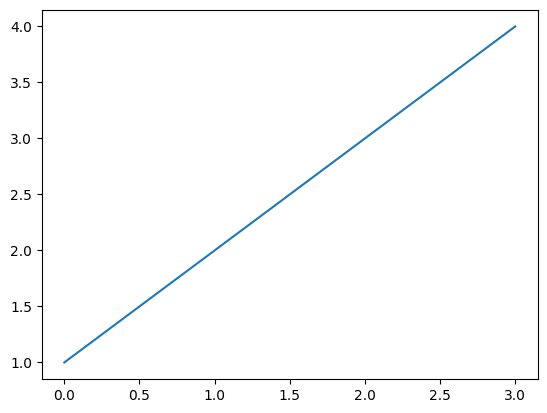

In [111]:
plt.plot([1,2,3,4])

In [112]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

In [113]:
batch_size = 64
learning_rate = 0.01
num_epochs = 30

In [114]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
train_data = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Download and load the test data
test_data = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [115]:
len(train_data)

60000

In [116]:
len(test_data)

10000

In [117]:
import random

In [118]:
valid_size = 0.2
test_size = 0.1
num_train = len(train_data) # 50000개 중에서 25000개 랜덤 추출 

indices = list(range(num_train)) # 0 ~ 24999
#sample_indices = random.sample(indices, num_train//2)
len(indices)
np.random.shuffle(indices) 


In [119]:
split = int(np.floor(valid_size * num_train)) # 0.2 * 10000
print(split)
train_idx, valid_idx = indices[split:], indices[:split] # train 20000, valid 5000 개씩 indices 리스트에서 랜덤한 인덱스 가져오기 
print(len(train_idx), len(valid_idx))

12000
48000 12000


In [120]:
num_test = len(test_data)
indices = list(range(num_test)) # 10000개 중에서 5000개 랜덤 추출 
#sample__test_indices = random.sample(indices, num_test//2)
np.random.shuffle(indices) 

In [121]:
test_idx = indices

In [122]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [123]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          sampler=test_sampler)

In [124]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("working on gpu")
else:
    device = torch.device("cpu")
    print("working on cpu")

working on gpu


In [125]:
classes= [0,1,2,3,4,5,6,7,8,9]

In [126]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(global_model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(global_model.parameters(),lr=0.001,weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [127]:
from tqdm import tqdm

In [129]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)

for e in range(0, n_epochs):
   
    ###################
    # train the model #
    ###################
    global_model.train()
    for data, labels in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device)
        
        # clear the gradients of all optimized variables
        
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = global_model(data)
        
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()
        
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape) # 모델의 출력과, 실제 정답 비교 
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    train_loss[e] /= len(train_loader)
    train_acc[e] /= len(train_loader)
    scheduler.step()
        
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        global_model.eval()
        
        torch.cuda.empty_cache()
        for data, labels in tqdm(valid_loader):
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = global_model(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # update average validation loss 
            valid_loss[e] += loss.item()

            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    # calculate average losses
    valid_loss[e] /= len(valid_loader)
    valid_acc[e] /= len(valid_loader)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
        e, train_acc[e], valid_acc[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(global_model.state_dict(), './model_file/global-update-3-mnist.pt')
        valid_loss_min = valid_loss[e]

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 69.73it/s]


Epoch: 0 	Training Loss: 0.116882 	Validation Loss: 0.085568
Epoch: 0 	Training accuracy: 0.967229 	Validation accuracy: 0.974817
Validation loss decreased (inf --> 0.085568).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 64.09it/s]


Epoch: 1 	Training Loss: 0.069526 	Validation Loss: 0.072154
Epoch: 1 	Training accuracy: 0.978896 	Validation accuracy: 0.979804
Validation loss decreased (0.085568 --> 0.072154).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.94it/s]


Epoch: 2 	Training Loss: 0.052708 	Validation Loss: 0.044964
Epoch: 2 	Training accuracy: 0.983708 	Validation accuracy: 0.987367
Validation loss decreased (0.072154 --> 0.044964).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 65.63it/s]


Epoch: 3 	Training Loss: 0.050152 	Validation Loss: 0.066582
Epoch: 3 	Training accuracy: 0.984292 	Validation accuracy: 0.982547


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 64.44it/s]


Epoch: 4 	Training Loss: 0.048064 	Validation Loss: 0.066473
Epoch: 4 	Training accuracy: 0.984604 	Validation accuracy: 0.979638


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 63.71it/s]


Epoch: 5 	Training Loss: 0.037363 	Validation Loss: 0.044273
Epoch: 5 	Training accuracy: 0.988104 	Validation accuracy: 0.986203
Validation loss decreased (0.044964 --> 0.044273).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 64.51it/s]


Epoch: 6 	Training Loss: 0.046973 	Validation Loss: 0.050379
Epoch: 6 	Training accuracy: 0.985042 	Validation accuracy: 0.985040


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 64.10it/s]


Epoch: 7 	Training Loss: 0.034748 	Validation Loss: 0.040177
Epoch: 7 	Training accuracy: 0.988250 	Validation accuracy: 0.988447
Validation loss decreased (0.044273 --> 0.040177).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 64.72it/s]


Epoch: 8 	Training Loss: 0.033900 	Validation Loss: 0.037928
Epoch: 8 	Training accuracy: 0.988813 	Validation accuracy: 0.988198
Validation loss decreased (0.040177 --> 0.037928).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 64.69it/s]


Epoch: 9 	Training Loss: 0.033586 	Validation Loss: 0.051492
Epoch: 9 	Training accuracy: 0.989125 	Validation accuracy: 0.984791


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:03<00:00, 60.50it/s]


Epoch: 10 	Training Loss: 0.014604 	Validation Loss: 0.030723
Epoch: 10 	Training accuracy: 0.995958 	Validation accuracy: 0.990525
Validation loss decreased (0.037928 --> 0.030723).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 63.09it/s]


Epoch: 11 	Training Loss: 0.011377 	Validation Loss: 0.031280
Epoch: 11 	Training accuracy: 0.996854 	Validation accuracy: 0.990525


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 64.74it/s]


Epoch: 12 	Training Loss: 0.010364 	Validation Loss: 0.030410
Epoch: 12 	Training accuracy: 0.997521 	Validation accuracy: 0.990359
Validation loss decreased (0.030723 --> 0.030410).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 64.87it/s]


Epoch: 13 	Training Loss: 0.009653 	Validation Loss: 0.031088
Epoch: 13 	Training accuracy: 0.997500 	Validation accuracy: 0.990359


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 70.24it/s]


Epoch: 14 	Training Loss: 0.009589 	Validation Loss: 0.030404
Epoch: 14 	Training accuracy: 0.997667 	Validation accuracy: 0.990608
Validation loss decreased (0.030410 --> 0.030404).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.37it/s]


Epoch: 15 	Training Loss: 0.008908 	Validation Loss: 0.031583
Epoch: 15 	Training accuracy: 0.997917 	Validation accuracy: 0.990276


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 64.87it/s]


Epoch: 16 	Training Loss: 0.008520 	Validation Loss: 0.031063
Epoch: 16 	Training accuracy: 0.998167 	Validation accuracy: 0.990608


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 65.27it/s]


Epoch: 17 	Training Loss: 0.007911 	Validation Loss: 0.032070
Epoch: 17 	Training accuracy: 0.998354 	Validation accuracy: 0.990359


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 64.70it/s]


Epoch: 18 	Training Loss: 0.007242 	Validation Loss: 0.031172
Epoch: 18 	Training accuracy: 0.998750 	Validation accuracy: 0.990525


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.00it/s]


Epoch: 19 	Training Loss: 0.007554 	Validation Loss: 0.032247
Epoch: 19 	Training accuracy: 0.998479 	Validation accuracy: 0.990691


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 66.37it/s]


Epoch: 20 	Training Loss: 0.005298 	Validation Loss: 0.030354
Epoch: 20 	Training accuracy: 0.999375 	Validation accuracy: 0.990858
Validation loss decreased (0.030404 --> 0.030354).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 63.55it/s]


Epoch: 21 	Training Loss: 0.005161 	Validation Loss: 0.030767
Epoch: 21 	Training accuracy: 0.999375 	Validation accuracy: 0.990442


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 65.99it/s]


Epoch: 22 	Training Loss: 0.005118 	Validation Loss: 0.030581
Epoch: 22 	Training accuracy: 0.999354 	Validation accuracy: 0.990359


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.45it/s]


Epoch: 23 	Training Loss: 0.004745 	Validation Loss: 0.030852
Epoch: 23 	Training accuracy: 0.999521 	Validation accuracy: 0.990858


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 65.03it/s]


Epoch: 24 	Training Loss: 0.004704 	Validation Loss: 0.030495
Epoch: 24 	Training accuracy: 0.999604 	Validation accuracy: 0.991024


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 65.33it/s]


Epoch: 25 	Training Loss: 0.004915 	Validation Loss: 0.030271
Epoch: 25 	Training accuracy: 0.999500 	Validation accuracy: 0.991024
Validation loss decreased (0.030354 --> 0.030271).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 64.04it/s]


Epoch: 26 	Training Loss: 0.005056 	Validation Loss: 0.030407
Epoch: 26 	Training accuracy: 0.999396 	Validation accuracy: 0.990775


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.35it/s]


Epoch: 27 	Training Loss: 0.004773 	Validation Loss: 0.030551
Epoch: 27 	Training accuracy: 0.999542 	Validation accuracy: 0.990525


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.87it/s]


Epoch: 28 	Training Loss: 0.004479 	Validation Loss: 0.030569
Epoch: 28 	Training accuracy: 0.999646 	Validation accuracy: 0.990858


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 63.53it/s]

Epoch: 29 	Training Loss: 0.004574 	Validation Loss: 0.030471
Epoch: 29 	Training accuracy: 0.999625 	Validation accuracy: 0.990775


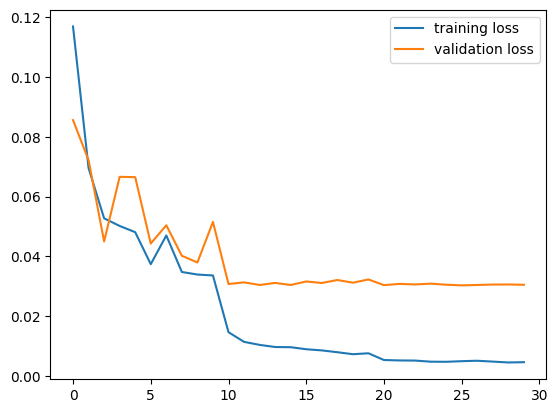

In [130]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label = 'training loss')
plt.plot(valid_loss, label = 'validation loss')
plt.legend()

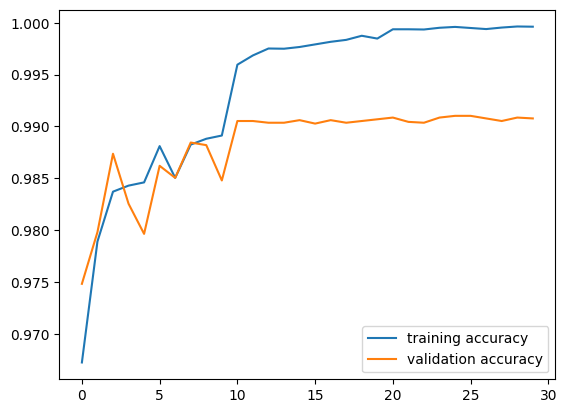

In [131]:
plt.plot(train_acc, label = 'training accuracy')
plt.plot(valid_acc, label = 'validation accuracy')
plt.legend()

In [132]:
pwd

'D:\\asy10\\FL_project\\mnist\\Server'

In [133]:
global_model.load_state_dict(torch.load('./model_file/global-update-3-mnist.pt'))

<All keys matched successfully>

In [134]:
# track test loss
test_loss = 0.0
test_acc = 0.0

class_correct = torch.zeros(100)
class_total = torch.zeros(100)

global_model.eval()
# iterate over test data
for data, labels in test_loader:
    # move tensors to GPU if CUDA is available
    data, labels = data.to(device), labels.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    logits = global_model(data)
    # calculate the batch loss
    loss = criterion(logits, labels)
    # update test loss 
    test_loss += loss.item()
    
    ps = F.softmax(logits, dim=1)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.reshape(top_class.shape)
    test_acc += torch.mean(equals.type(torch.float)).detach().cpu()
    
    for i in range(len(data)):
        label = labels[i]
        class_correct[label] += equals[i].item()
        class_total[label] += 1
    

# average test loss
test_loss = test_loss/len(test_loader)
test_acc = test_acc/len(test_loader)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Test Accuracy: {:.6f}\n'.format(test_acc))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            torch.sum(class_correct[i]), torch.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

Test Loss: 0.023202

Test Accuracy: 0.992635

Test Accuracy of     0: 99% (977/980)
Test Accuracy of     1: 99% (1133/1135)
Test Accuracy of     2: 99% (1027/1032)
Test Accuracy of     3: 99% (1006/1010)
Test Accuracy of     4: 99% (977/982)
Test Accuracy of     5: 99% (884/892)
Test Accuracy of     6: 98% (944/958)
Test Accuracy of     7: 98% (1017/1028)
Test Accuracy of     8: 99% (967/974)
Test Accuracy of     9: 98% (994/1009)


In [135]:
torch.save(global_model, './model_file/global-update-3-mnist.pt')